In [2]:
%pylab inline 
import numpy as np
import xarray as xr
import pandas as pd
import glob
import netCDF4
from pyresample import kd_tree,geometry,utils
import os
from datetime import datetime,timedelta
from dateutil.rrule import rrule, DAILY
from pytz import timezone
import pytz
import resource
from netCDF4 import Dataset
import fnmatch
from skimage.measure import regionprops
from scipy.ndimage.measurements import label
from scipy.signal import convolve2d
from skimage.filters import sobel
from skimage.morphology import convex_hull_image
from matplotlib.collections import PolyCollection
from scipy.spatial import ConvexHull
import glob2
import scipy.io as sio
from pyhdf.SD import SD, SDC
from area import area 
from astropy.nddata import bitmask
from scipy.spatial import Delaunay
import h5py
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster
from dask.distributed import progress

Populating the interactive namespace from numpy and matplotlib


In [1]:
def ascatb_gfs(cur_file):
    import numpy as np
    import xarray as xr
    import pandas as pd
    import glob
    import netCDF4
    from pyresample import kd_tree,geometry,utils
    import os
    from datetime import datetime,timedelta
    from dateutil.rrule import rrule, DAILY
    from pytz import timezone
    import pytz
    import resource
    from netCDF4 import Dataset
    import fnmatch
    from skimage.measure import regionprops
    from scipy.ndimage.measurements import label
    from scipy.signal import convolve2d
    from skimage.filters import sobel
    from skimage.morphology import convex_hull_image
    from matplotlib.collections import PolyCollection
    from scipy.spatial import ConvexHull
    import glob2
    import scipy.io as sio
    from pyhdf.SD import SD, SDC
    from area import area 
    from astropy.nddata import bitmask
    from scipy.spatial import Delaunay
    import h5py
    
    np.warnings.filterwarnings('ignore')
    pd.options.mode.chained_assignment = None
    file = os.path.basename(cur_file)                                              #Read the file name
    fname = file.split('.')[0]                                                     
    #print(fname)
    orbit = fname.split('_')[4]
    #print(orbit)
    f = xr.open_dataset(cur_file)
    wsp = f.wind_speed.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
    alo = f.lon.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
    ala = f.lat.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
    wdir = f.wind_dir.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
    bitf = f.wvc_quality_flag.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
    tim = f.time.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)

    bit_mask = bitmask.bitfield_to_boolean_mask(bitf.values.astype(int),ignore_flags=[2**11,2**12,2**14],
                                        dtype=int,good_mask_value=1.)

    wind = bit_mask*wsp.values
    dire = bit_mask*wdir.values

    alons = alo.values
    alats = ala.values
    time = tim.values
    
    
    f.close()
    uin = wind*np.sin((np.pi/180.)*dire)
    vin = wind*np.cos((np.pi/180.)*dire)
        #def gradient_features(uin,vin,time,alons,alats,orbit):
    def gradient_gfs(uin,vin,alons,alats,time):
        smooth = 1.0                                                 #order of derivative
        res = 12500.0                                                # Field of View of ASCAT (m)
        dxx = np.zeros((uin.shape[0],uin.shape[1]))                  #First Derivative in x
        dyy = np.zeros((vin.shape[0],vin.shape[1]))                  #First Derivative in y

        grad_u = np.zeros((uin.shape[0],uin.shape[1]))               #Empty array for zonal wind gradient
        grad_v = np.zeros((vin.shape[0],vin.shape[1]))               #Empty array for meridional wind gradient
        divg = np.zeros((uin.shape[0],uin.shape[1]))                 #  "     "    "  horizontal divergence
        vort = np.zeros((uin.shape[0],uin.shape[1]))                 #  "     "    "  horizontal vorticity
        #ow_asc = np.zeros((uin.shape[0],uin.shape[1]))               #  "     "    "  Okubo-Weiss Parameter

        x = np.int(smooth)                               
        matrix = np.ones((x,x),dtype='float')/x**2                   #Defining matrix for derivatives
        smu = convolve2d(uin,matrix,mode='same',boundary='symm',fillvalue=-999.0)    #Linear Convolution of u
        smv = convolve2d(vin,matrix,mode='same',boundary='symm',fillvalue=-999.0)    #Linear Convolution of v
        dxx[:]=res                                                 #derivatives in x at 12500m FOV
        dyy[:]=res                                                 #derivatives in y at 12500m FOV
        dqu_dy,dqu_dx = np.gradient(smu[:,:],res,res)            #zonal derivative of u
        dqv_dy,dqv_dx = np.gradient(smv[:,:],res,res)            #meridional derivative of v
        grad_u = dqu_dx + dqv_dx                                 #gradient in u (s^-1)
        grad_v = dqu_dy + dqv_dy                                 #gradient in v (s^-1)
        divg = dqu_dx + dqv_dy                                   #horizontal divergence (s^-1)
        vort = dqv_dx - dqu_dy                                   #horizontal vorticity (s^-1)
        #ow_asc = ((vort)**2) - ((dqu_dx - dqv_dy)**2) - ((dqv_dx+dqu_dy)**2)      #Okubo-Weiss Parameter (s^-2)

        speed = np.sqrt(grad_u**2+grad_v**2)                     #Magnitude of horizontal wind gradient (s^-1)

        speed_asc = sobel(speed)                                 #Applying Sobel method to detect gradient edge
                                                                 #(http://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm)
        gf = np.zeros(speed_asc.shape)                           #Creating the empty array to get the GFs

        gf[speed_asc>6.8e-5] = 1                           #Applying First Threshold of 6.8e-5 s^-1 on gradient

        gf_id,num_gfs = label(gf)                          #Using skimage label to mark every single feature crossing the first threshold
        for i in np.arange(0,np.max(gf_id)):              #Applying secondary threshold of 1.2e-4 s^-1
            ingf = np.where(gf_id==i)
            maxval = np.max(speed_asc[ingf])
            if maxval <= 1.2e-4:
                gf[ingf] = 0

        gf_id1,num_gf1 = label(gf)                        #Labeling the final array of GFs

        regions_new = regionprops(gf_id1,speed_asc)       #Using scipy regionprops to obtain GF characteristics 
        gpix = np.zeros(len(regions_new))
        grad_new = []
        for eachgrad in np.arange(0,np.max(gf_id1)):      #Check if there are atleast 4 pixels in a given GF anf its in tropics
            gpix = regions_new[eachgrad].area
            if gpix >=4:
                grad_new.append(eachgrad)

        ds = xr.Dataset()
        ds['lons'] = xr.DataArray(alons,dims=['along_track','cross_track'])

        ds['grad_asc'] = xr.DataArray(speed_asc,dims=['along_track','cross_track'])
        ds['divg_asc'] = xr.DataArray(divg,dims=['along_track','cross_track'])
        ds['vort_asc'] = xr.DataArray(vort,dims=['along_track','cross_track'])
        ds['u'] = xr.DataArray(uin,dims=['along_track','cross_track'])
        ds['v'] = xr.DataArray(vin,dims=['along_track','cross_track'])

        ds['lats'] = xr.DataArray(alats,dims=['along_track','cross_track'])

        #Identify the first observation time of ASCAT-swath
        t_m = datetime.strptime(pd.to_datetime(time[0][0]).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')

        #Open the MERRA2 files for +- 1.5 days from the ASCAT time
        t_m1 = t_m-timedelta(days=1.5)
        t_m2 = t_m+timedelta(days=1.5)

        merra1 = np.load('/data/gpm/a/pgarg7/merra_ocn/merra_ocn_clim.npy')
        merra2 = np.load('/data/gpm/a/pgarg7/merra_flx/merra_flx_clim.npy')

        #Getting the names of the MERRA-2 files
        merra1_d = np.array([os.path.basename(x.decode('utf-8')).split('.') for x in merra1])           
        merra2_d = np.array([os.path.basename(x.decode('utf-8')).split('.') for x in merra2])

        #Extracting the dates for each MERRA-2 file
        merra1_dates = np.array([datetime.strptime(str(merra1_d[x,2]),'%Y%m%d') for x in range(len(merra1_d))])
        merra2_dates = np.array([datetime.strptime(str(merra2_d[x,2]),'%Y%m%d') for x in range(len(merra2_d))])

        #Open MERRA2 Flux and Ocean Files files
        merra1_open = merra1[(merra1_dates>t_m1)&(merra1_dates<t_m2)]
        merra2_open = merra2[(merra2_dates>t_m1)&(merra2_dates<t_m2)]

        #merra1_open.astype(str)

        merra1_open = [x.decode('utf-8') for x in merra1_open]
        merra2_open = [x.decode('utf-8') for x in merra2_open]

        merra1_m = xr.open_mfdataset(merra1_open,chunks=None,concat_dim='time')
        merra2_m = xr.open_mfdataset(merra2_open,chunks=None,concat_dim='time')

        #Checking nearest MERRA2 time with ASCAT time
        m1_index = np.argmin(np.array(abs(pd.to_datetime(merra1_m['time'].values)-t_m)))
        m2_index = np.argmin(np.array(abs(pd.to_datetime(merra2_m['time'].values)-t_m)))

        merra_ocn = merra1_m.isel(time=m1_index)

        #Reindexing longitudes of MERRA-2 to 0-360 format
        merra_ocn2 = merra_ocn.assign(**{'lon': np.mod(merra_ocn['lon'], 360)})

        merra_ocn3 = merra_ocn2.reindex({ 'lon' : np.sort(merra_ocn2['lon'])})
        
        merra1_m.close()

        merra_flux = merra2_m.isel(time=m2_index)

        merra_flux2 = merra_flux.assign(**{'lon': np.mod(merra_flux['lon'], 360)})

        merra_flux3 = merra_flux2.reindex({'lon': np.sort(merra_flux2['lon'])})
        merra2_m.close()
        
        #Check TRMM times for +- 6 hours of ASCAT time
        t1 = t_m-timedelta(hours=6)
        t2 = t_m+timedelta(hours=6)

        #Load TRMM 3B42 data
        trmm_files = np.load('/data/gpm/a/pgarg7/trmm_3b42_hdf/arthurhou.pps.eosdis.nasa.gov/trmmdata/ByDate/V07/trmm_files.npy')
        trmm_d = np.array([os.path.basename(x.decode('utf-8')).split('_') for x in trmm_files]) #Split to get the file name
        trmm_da = np.array([x[0].split('.') for x in trmm_d])                  #Split the file name to get dates

        #Obtain the array of TRMM dates
        t_dates=np.array([datetime.strptime(str(trmm_da[x,1])+str(trmm_da[x,2]+str('00')+str('00')),'%Y%m%d%H%M%S') 
                          for x in range(len(trmm_da))])

        #Open TRMM files
        trmm_open_dates = trmm_files[(t_dates>t1)&(t_dates<t2)]
        da = t_dates[(t_dates>t1)&(t_dates<t2)]

        times = []
        for i in range(len(da)):                   #Check if the difference between ASCAT and TRMM time is minimum
            timedelta1 = abs(pd.to_datetime(da[i])-t_m)
            times.append(timedelta1)

        trmm_hdf = SD(trmm_open_dates[times.index(min(times))].decode('utf-8'))           #Open selected TRMM file

        sds_obj = trmm_hdf.select('precipitation')                       #Select Precipitation data from TRMM

        precip = sds_obj.get()                                           #Get Precip data
        precip = precip[:]
        precip = np.transpose(precip)
        
        trmm_hdf.end()
        #Reindex TRMM lat-lon to -180to180
        precip_x = xr.Dataset()                                     
        theLats = np.float32(np.arange(-49.875,50,0.25))
        theLons = np.float32(np.arange(-179.875,180,0.25))

        precip_x = xr.Dataset()                                        
        precip_x.coords['lat'] = (('lat'),theLats)
        precip_x.coords['lon'] = (('lon'),theLons)

        precip_x['trmm_precip'] = (('lat','lon'),precip)

        precip_y = np.zeros((400,1440))
        precip_y[:,0:720] = precip_x.trmm_precip.values[:,720:1440]
        precip_y[:,720:1440] = precip_x.trmm_precip.values[:,0:720]
        precip_x.trmm_precip.values[:] = precip_y[:]
        lons_360 = np.remainder(theLons,360.)
        lons_x = np.zeros(1440)
        lons_x[0:720] = lons_360[720:1440]
        lons_x[720:1440] = lons_360[0:720]
        lons_360[:] = lons_x[:]

        precip_z = xr.Dataset()

        precip_z.coords['lat'] = (('lat'),theLats)
        precip_z.coords['lon'] = (('lon'),lons_360)
        precip_z['trmm_precip'] = (('lat','lon'),precip_x.trmm_precip.values[:])         #Reindexed TRMM dataset
        precip_x.close()

        data = pd.DataFrame(index=np.arange(0,len(grad_new)),
                       columns=['time','weighted_centroid_x','weighted_centroid_y','num_pix','eccent','fill',
                               'majaxis','maxint','meanint','minint','orient','perim','solid','convex_area',
                               'wcent_lon','wcent_lat','gf_size','sst_centroid','t2m_centroid','qv2m_centroid',
                               'shflux_mean_asc','lhflux_mean_asc','shflux_mean_mer','lhflux_mean_mer',
                               'mean_gf_precip'])

        #-------Functions to regrid MERRA-2 datasets to ASCAT footrpint 
        def rgrd_flux(var,swath_def,grid_def):
            var1 = kd_tree.resample_gauss(grid_def,var,
                                         swath_def,radius_of_influence=25000.,sigmas=12500.)
            return var1
        #import time as t
        #start = t.time()
        for k in np.arange(0,len(grad_new)):
            #try: #Trying if there is no GF in the array. If there is none, pass to the next array
                #print k
            coords_x = alons[regions_new[grad_new[k]].coords[:,0],regions_new[grad_new[k]].coords[:,1]]  #Lons of GF
            coords_y = alats[regions_new[grad_new[k]].coords[:,0],regions_new[grad_new[k]].coords[:,1]]  #Lats of GF

            data.num_pix[k] = regions_new[grad_new[k]].area             #Number of pixels in the GF
            wcx,wcy = regions_new[grad_new[k]].centroid                 #Centroid of GF
            data.weighted_centroid_x[k] = wcx
            data.weighted_centroid_y[k] = wcy
            data.eccent[k] = regions_new[grad_new[k]].eccentricity      #Eccentricity(0-1) of GF;0-Circle, 1-Ellipse
            data.fill[k] = regions_new[grad_new[k]].filled_area        #Total Number of Pixels in GF with filled holes
            data.majaxis[k] = regions_new[grad_new[k]].major_axis_length  #Length of major axis of GF 
            data.maxint[k] = regions_new[grad_new[k]].max_intensity       #Value of Maximum intensity in the GF
            data.meanint[k] = regions_new[grad_new[k]].mean_intensity     #Value of Mean intensity
            data.minint[k] = regions_new[grad_new[k]].min_intensity       #Value of Minimum intensity
            data.orient[k] = regions_new[grad_new[k]].orientation         #Angle between 0th and major axis of ellipse
            data.perim[k] = regions_new[grad_new[k]].perimeter            #Total perimeter of the GF polygon
            data.solid[k] = regions_new[grad_new[k]].solidity             #Ratio of pixels in the region to pixels of the convex hull image.
            data.convex_area[k] = regions_new[grad_new[k]].convex_area    #Total number of convex hull pixels
            data.wcent_lon[k] = alons[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]  #Longitude Centroid
            data.wcent_lat[k] = alats[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]  #Latitude Centroid
            data.time[k] = pd.to_datetime(time[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])])   #GF Centroid Time
            data.time[k] = pd.to_datetime(data.time[k])

            points = np.vstack((coords_x,coords_y)).T
            obj = {'type':'Polygon','coordinates':[points.tolist()]}       #Dictionary of GF coordinates
            data.gf_size[k] = area(obj)/1e6                               #Area of GF in Km^2

            swath_lon = ds.lons.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                           ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
            swath_lat = ds.lats.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                           ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values

            merra_osub = merra_ocn3.sel(lon=slice(data.wcent_lon[k]-8.,data.wcent_lon[k]+8.),
                                       lat=slice(data.wcent_lat[k]-8.,data.wcent_lat[k]+8.))

            merra_fsub = merra_flux3.sel(lon=slice(data.wcent_lon[k]-8.,data.wcent_lon[k]+8.),
                                            lat=slice(data.wcent_lat[k]-8.,data.wcent_lat[k]+8.))
            
            merra_ocn3.close()
            merra_flux3.close()

            #Identifying SST, 2m Temperature and Specific Humidity nearest to GF centroid 
            #sst_da = merra_osub['TSKINWTR']
            data.sst_centroid[k] = merra_osub['TSKINWTR'].sel(lon=data.wcent_lon[k],lat=data.wcent_lat[k],method='nearest').values
            #t2_da = merra_fsub['TLML']
            data.t2m_centroid[k] = merra_fsub['TLML'].sel(lon=data.wcent_lon[k],lat=data.wcent_lat[k],method='nearest').values
            #q2_da = merra_fsub['QLML']
            data.qv2m_centroid[k] = merra_fsub['QLML'].sel(lon=data.wcent_lon[k],lat=data.wcent_lat[k],method='nearest').values

            #data.sst_centroid[k] = sst_d.values
            #data.t2m_centroid[k] = t2_d.values
            #data.qv2m_centroid[k] = q2_d.values

            #MERRA-2 calculations similar to ASCAT wind calculations
            lon_ocn = merra_osub['lon'].values
            lat_ocn = merra_osub['lat'].values

            lon_flx = merra_fsub['lon'].values
            lat_flx = merra_fsub['lat'].values

            u_m = merra_osub['U10M'].values
            v_m = merra_osub['V10M'].values

            smooth_m = 1.0
            res_x = 50000.0
            res_y = 62500.0
            dxx_m = np.zeros((u_m.shape[0],u_m.shape[1]))
            dyy_m = np.zeros((v_m.shape[0],v_m.shape[1]))

            grad_u_m = np.zeros((u_m.shape[0],u_m.shape[1]))
            grad_v_m = np.zeros((v_m.shape[0],v_m.shape[1]))
            divg_m = np.zeros((u_m.shape[0],u_m.shape[1]))
            vort_m = np.zeros((u_m.shape[0],u_m.shape[1]))
            ow_mer = np.zeros((u_m.shape[0],u_m.shape[1]))

            x_m = np.int(smooth_m)
            matrix_m = np.ones((x_m,x_m),dtype='float')/x_m**2
            smu_m = convolve2d(u_m,matrix_m,mode='same',boundary='symm',fillvalue=-999.0)
            smv_m = convolve2d(v_m,matrix_m,mode='same',boundary='symm',fillvalue=-999.0)
            dxx_m[:]=res_x
            dyy_m[:]=res_y
            dqu_dy_m,dqu_dx_m = np.gradient(smu_m[:,:],res_y,res_x)
            dqv_dy_m,dqv_dx_m = np.gradient(smv_m[:,:],res_y,res_x)
            grad_u_m = dqu_dx_m + dqv_dx_m
            grad_v_m = dqu_dy_m + dqv_dy_m
            divg_m = dqu_dx_m + dqv_dy_m
            vort_m = dqv_dx_m - dqu_dy_m
            ow_mer = ((vort_m)**2) - ((dqu_dx_m-dqv_dy_m)**2) - ((dqv_dx_m+dqu_dy_m)**2)


            #---------------Creating Geometries to regird MERRA-2
            #lon_asc = ds['lon'].values
            #lat_asc = ds['lat'].values

            lono,lato = np.meshgrid(lon_ocn,lat_ocn)         
            lonf,latf = np.meshgrid(lon_flx,lat_flx)

            #lonf1,latf1 = pyresample.utils.check_and_wrap(lonf,latf)
            #lono1,lato1 = pyresample.utils.check_and_wrap(lono,lato)
            #sw_lon,sw_lat = pyresample.utils.check_and_wrap(swath_lon,swath_lat)
            flux_def = geometry.SwathDefinition(lons=lonf,lats=latf)
            ocn_def = geometry.SwathDefinition(lons=lono,lats=lato)
            asc_def = geometry.SwathDefinition(lons=swath_lon,lats=swath_lat)

            rhoa = rgrd_flux(merra_fsub['RHOA'].values,asc_def,flux_def)   #Density(kg/m^3)
            sst = rgrd_flux(merra_osub['TSKINWTR'].values,asc_def,ocn_def) #SST (K)
            t10m = rgrd_flux(merra_osub['T10M'].values,asc_def,ocn_def)  #10m Temp (K)
            t2m = rgrd_flux(merra_fsub['TLML'].values,asc_def,flux_def)    #2m Temp(K)
            qv2m = rgrd_flux(merra_fsub['QLML'].values,asc_def,flux_def)   #2m specific humidity
            qv10 = rgrd_flux(merra_osub['QV10M'].values,asc_def,ocn_def)   #10m specific humidity
            hflux_mer = rgrd_flux(merra_fsub['HFLUX'].values,asc_def,flux_def) #MERRA-2 Sensible flux (W/m^2)
            eflux_mer = rgrd_flux(merra_fsub['EFLUX'].values,asc_def,flux_def) #MERRA-2 Latent Flux (W/m^2)
            divg_mer = rgrd_flux(divg_m,asc_def,ocn_def)   #MERRA-2 divergence
            vort_mer = rgrd_flux(vort_m,asc_def,ocn_def)   #MERRA-2 vorticity
            
            merra_osub.close()
            merra_fsub.close()
            
            ps = np.zeros(sst.shape)                           #Surface Pressure (hPa)
            ps = rhoa*287.*sst
            ps = ps/100.

            es = np.zeros(np.shape(ps))                   #Surface vapor pressure (hPa)
            T = np.zeros(np.shape(ps))                    #Surface Temp (C)
            T = sst - 273.15 
            es = 611.2*np.exp((17.67*T)/(T+243.5))
            es = es/100
            q = np.zeros(es.shape)     #Specific Humidity (Kg/m^3)
            q = ((0.622*es)/(ps))

            u_asc = ds.u.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                           ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
            v_asc = ds.v.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                           ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values

            grad_asc = ds.grad_asc.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                           ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
            divg_asc = ds.divg_asc.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                           ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
            vort_asc = ds.vort_asc.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                           ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
            ds.close()
            U10 = np.sqrt((u_asc**2)+(v_asc**2))          #10m surface winds 

            qs = np.zeros(U10.shape)     #Sensible Heat Flux with ASCAt winds (W/m^2)
            ql = np.zeros(U10.shape)     #Latent Heat Flux with ASCAT winds (W/m^2)

            qs = rhoa*1004.*(1.1*10**(-3))*U10*sst-t10m
            ql = rhoa*(2.5e6)*(1.2*10**(-3))*U10*(q-qv10)

            #ds['hflux_asc'] = (('scan','ray'),qs)
            #ds['eflux_asc'] = (('scan','ray'),ql)

            #-------MERRA-2 calculations corresponding to respective GFs
            #lon_gf = coords_x
            #lat_gf = coords_y

            lon_grid,lat_grid = np.meshgrid(coords_x,coords_y)
            #long1,latg1 = pyresample.utils.check_and_wrap(lon_grid,lat_grid)

            gf_def = geometry.SwathDefinition(lons=lon_grid,lats=lat_grid) #GF geometry

            qs_gf = rgrd_flux(qs,gf_def,asc_def)
            ql_gf = rgrd_flux(ql,gf_def,asc_def)

            qs_gf_mer = rgrd_flux(hflux_mer,gf_def,asc_def)
            ql_gf_mer = rgrd_flux(eflux_mer,gf_def,asc_def)

            data.shflux_mean_asc[k] = np.mean(qs_gf)
            data.lhflux_mean_asc[k] = np.mean(ql_gf)
            data.shflux_mean_mer[k] = np.mean(qs_gf_mer)
            data.lhflux_mean_mer[k] = np.mean(ql_gf_mer)
            #---------Saving all the MERRA-2 parameters corresponding to swath and GFs-----------------
            #---------TRMM Preciptiation corresponding to GFs
            trmm_sub = precip_z.sel(lon=slice(data.wcent_lon[k]-8.,data.wcent_lon[k]+8.),     #Subsetting TRMM data corresponding to GFs
                                    lat=slice(data.wcent_lat[k]-8.,data.wcent_lat[k]+8.))

            lon_cm = trmm_sub['lon'].values   
            lat_cm = trmm_sub['lat'].values

            precip_z.close()
            
            lon_c,lat_c = np.meshgrid(lon_cm,lat_cm)

            trmm_def = geometry.SwathDefinition(lons=lon_c,lats=lat_c)   #Defining TRMM geometry 
            precip_tot = rgrd_flux(trmm_sub['trmm_precip'].values,asc_def,trmm_def)

            #precip = (('scan','ray'),precip_tot)     #recip in the Swath (mm/hr)

            #data.num_precip_pix[k] = np.count_nonzero(precip_tot)

            precip_gf = rgrd_flux(trmm_sub['trmm_precip'].values,gf_def,trmm_def)   #Total Precip in GF swath (mm/hr)
            #data.num_gfrain_pix[k] = np.count_nonzero(precip_gf)     #Number of Rainy Pixels in GF

            #data.rain_fraction[k] = data.num_gfrain_pix[k]/data.num_precip_pix[k]  #Total Rain Fraction in GFs
            trmm_sub.close()
            data.mean_gf_precip[k] = precip_gf[precip_gf.nonzero()].mean()        #Mean GF Precip (mm/hr)

            folderstr=datetime.strftime(pd.to_datetime(time[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]),'/%Y/%m/%d')                     #Creating folder for each time 
            os.system('mkdir -p /data/gpm/a/pgarg7/test_rapid/GFI/'+folderstr)

            if os.path.isfile('/data/gpm/a/pgarg7/test_rapid/GFI/{folderstr}/GF_{orbit}_{time}_{k}.h5'
                              .format(time=pd.to_datetime(time[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]).isoformat(),k=k,folderstr=folderstr,orbit=orbit)):
                print("File already exists")
            else:
                with h5py.File('/data/gpm/a/pgarg7/test_rapid/GFI/{folderstr}/GF_{orbit}_{time}_{k}.h5'
                              .format(time=pd.to_datetime(time[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]).isoformat(),k=k,folderstr=folderstr,orbit=orbit),'w') as hf:
                    hf.create_dataset("lon",data=swath_lon,compression="gzip", compression_opts=9)
                    hf.create_dataset("lat",data=swath_lat,compression="gzip", compression_opts=9)
                    hf.create_dataset("uin",data=u_asc,compression="gzip", compression_opts=9)
                    hf.create_dataset("vin",data=v_asc,compression="gzip", compression_opts=9)
                    hf.create_dataset("coords_x",data=coords_x,compression="gzip", compression_opts=9)
                    hf.create_dataset("coords_y",data=coords_y,compression="gzip", compression_opts=9)
                    hf.create_dataset("grad",data=grad_asc,compression="gzip", compression_opts=9)
                    hf.create_dataset("divg",data=divg_asc,compression="gzip", compression_opts=9)
                    hf.create_dataset("vort",data=vort_asc,compression="gzip", compression_opts=9)
                    hf.create_dataset("divg_m",data=divg_mer,compression="gzip", compression_opts=9)
                    hf.create_dataset("vort_m",data=vort_mer,compression="gzip", compression_opts=9)
                    hf.create_dataset("hflux_asc",data=ql,compression="gzip", compression_opts=9)
                    hf.create_dataset("eflux_asc",data=qs,compression="gzip", compression_opts=9)
                    hf.create_dataset("hflux_mer",data=hflux_mer,compression="gzip", compression_opts=9)
                    hf.create_dataset("eflux_mer",data=eflux_mer,compression="gzip", compression_opts=9)
                    hf.create_dataset("trmm_precip",data=precip_tot,compression="gzip", compression_opts=9)
            print(k)
        return data
    
    swath = gradient_gfs(uin,vin,alons,alats,time)
        
    folderstr=datetime.strftime(pd.to_datetime(time[0][0]),'/%Y/%m/%d')  
    os.system('mkdir -p /data/gpm/a/pgarg7/test_rapid/GFD/'+folderstr)

    if os.path.isfile('/data/gpm/a/pgarg7/test_rapid/GFD/{folderstr}/swath_{fname}.csv'
                      .format(folderstr=folderstr,fname=fname)):
        print("File exists!!")
    else:
        swath.to_csv('/data/gpm/a/pgarg7/test_rapid/GFD/{folderstr}/swath_{fname}.csv'
                      .format(folderstr=folderstr,fname=fname),index = False)
    #except:
        #print("Corrupt File")
        #pass
    return 

    #end = t.time()
    #print(end - start)

In [3]:
files = np.array(np.sort(glob2.glob('/data/accp/a/pgarg7/ascatb/*.nc')))
files

array(['/data/accp/a/pgarg7/ascatb/ascat_20121029_010301_metopb_00588_eps_o_coa_2101_ovw.l2_subset.nc',
       '/data/accp/a/pgarg7/ascatb/ascat_20121029_024201_metopb_00589_eps_o_coa_2101_ovw.l2_subset.nc',
       '/data/accp/a/pgarg7/ascatb/ascat_20121029_042400_metopb_00590_eps_o_coa_2101_ovw.l2_subset.nc',
       ...,
       '/data/accp/a/pgarg7/ascatb/ascat_20181230_192100_metopb_32607_eps_o_coa_3201_ovw.l2_subset.nc',
       '/data/accp/a/pgarg7/ascatb/ascat_20181230_210300_metopb_32608_eps_o_coa_3201_ovw.l2_subset.nc',
       '/data/accp/a/pgarg7/ascatb/ascat_20181230_224500_metopb_32609_eps_o_coa_3201_ovw.l2_subset.nc'],
      dtype='<U93')

In [18]:
cur_file = files[0]
file = os.path.basename(cur_file)                                              #Read the file name
file
fname = file.split('.')[0]                                                     
print(fname)
orbit = fname.split('_')[4]
print(orbit)

ascat_20121029_010301_metopb_00588_eps_o_coa_2101_ovw
00588


In [6]:
test = xr.open_dataset(files[0])


In [4]:
ascatb_gfs(files[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


KeyboardInterrupt: 

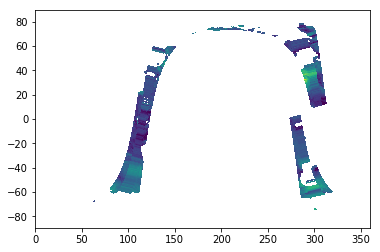

In [24]:
plt.pcolormesh(test.lon.values,test.lat.values,test.wind_speed.values)
plt.show()


In [27]:
t = test.time.values

In [30]:
t[0][0]

numpy.datetime64('2012-10-29T01:03:01.000000000')

In [3]:
#def ascatb_gfs(cur_file):
import numpy as np
import xarray as xr
import pandas as pd
import glob
import netCDF4
from pyresample import kd_tree,geometry,utils
import os
from datetime import datetime,timedelta
from dateutil.rrule import rrule, DAILY
from pytz import timezone
import pytz
import resource
from netCDF4 import Dataset
import fnmatch
from skimage.measure import regionprops
from scipy.ndimage.measurements import label
from scipy.signal import convolve2d
from skimage.filters import sobel
from skimage.morphology import convex_hull_image
from matplotlib.collections import PolyCollection
from scipy.spatial import ConvexHull
import glob2
import scipy.io as sio
from pyhdf.SD import SD, SDC
from area import area 
from astropy.nddata import bitmask
from scipy.spatial import Delaunay
import h5py

cur_file = files[0]
np.warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
file = os.path.basename(cur_file)                                              #Read the file name
fname = file.split('.')[0]                                                     
#print(fname)
orbit = fname.split('_')[4]
#print(orbit)
f = xr.open_dataset(cur_file)
wsp = f.wind_speed.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
alo = f.lon.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
ala = f.lat.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
wdir = f.wind_dir.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
bitf = f.wvc_quality_flag.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)
tim = f.time.where(((f.lat>=-31.)&(f.lat<=31.)),drop=True)

bit_mask = bitmask.bitfield_to_boolean_mask(bitf.values.astype(int),ignore_flags=[2**11,2**12,2**14],
                                    dtype=int,good_mask_value=1.)

wind = bit_mask*wsp.values
dire = bit_mask*wdir.values

alons = alo.values
alats = ala.values
time = tim.values


#f.close()

In [4]:
time.shape

(1132, 82)

In [5]:
uin = wind*np.sin((np.pi/180.)*dire)
vin = wind*np.cos((np.pi/180.)*dire)
#def gradient_features(uin,vin,time,alons,alats,orbit):
#def gradient_gfs(uin,vin,alons,alats,time):
smooth = 1.0                                                 #order of derivative
res = 12500.0                                                # Field of View of ASCAT (m)
dxx = np.zeros((uin.shape[0],uin.shape[1]))                  #First Derivative in x
dyy = np.zeros((vin.shape[0],vin.shape[1]))                  #First Derivative in y

grad_u = np.zeros((uin.shape[0],uin.shape[1]))               #Empty array for zonal wind gradient
grad_v = np.zeros((vin.shape[0],vin.shape[1]))               #Empty array for meridional wind gradient
divg = np.zeros((uin.shape[0],uin.shape[1]))                 #  "     "    "  horizontal divergence
vort = np.zeros((uin.shape[0],uin.shape[1]))                 #  "     "    "  horizontal vorticity
#ow_asc = np.zeros((uin.shape[0],uin.shape[1]))               #  "     "    "  Okubo-Weiss Parameter

x = np.int(smooth)                               
matrix = np.ones((x,x),dtype='float')/x**2                   #Defining matrix for derivatives
smu = convolve2d(uin,matrix,mode='same',boundary='symm',fillvalue=-999.0)    #Linear Convolution of u
smv = convolve2d(vin,matrix,mode='same',boundary='symm',fillvalue=-999.0)    #Linear Convolution of v
dxx[:]=res                                                 #derivatives in x at 12500m FOV
dyy[:]=res                                                 #derivatives in y at 12500m FOV
dqu_dy,dqu_dx = np.gradient(smu[:,:],res,res)            #zonal derivative of u
dqv_dy,dqv_dx = np.gradient(smv[:,:],res,res)            #meridional derivative of v
grad_u = dqu_dx + dqv_dx                                 #gradient in u (s^-1)
grad_v = dqu_dy + dqv_dy                                 #gradient in v (s^-1)
divg = dqu_dx + dqv_dy                                   #horizontal divergence (s^-1)
vort = dqv_dx - dqu_dy                                   #horizontal vorticity (s^-1)
#ow_asc = ((vort)**2) - ((dqu_dx - dqv_dy)**2) - ((dqv_dx+dqu_dy)**2)      #Okubo-Weiss Parameter (s^-2)

speed = np.sqrt(grad_u**2+grad_v**2)                     #Magnitude of horizontal wind gradient (s^-1)

speed_asc = sobel(speed)                                 #Applying Sobel method to detect gradient edge
                                                         #(http://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm)
gf = np.zeros(speed_asc.shape)                           #Creating the empty array to get the GFs

gf[speed_asc>6.8e-5] = 1                           #Applying First Threshold of 6.8e-5 s^-1 on gradient

gf_id,num_gfs = label(gf)                          #Using skimage label to mark every single feature crossing the first threshold
for i in np.arange(0,np.max(gf_id)):              #Applying secondary threshold of 1.2e-4 s^-1
    ingf = np.where(gf_id==i)
    maxval = np.max(speed_asc[ingf])
    if maxval <= 1.2e-4:
        gf[ingf] = 0

gf_id1,num_gf1 = label(gf)                        #Labeling the final array of GFs

regions_new = regionprops(gf_id1,speed_asc)       #Using scipy regionprops to obtain GF characteristics 
gpix = np.zeros(len(regions_new))
grad_new = []
for eachgrad in np.arange(0,np.max(gf_id1)):      #Check if there are atleast 4 pixels in a given GF anf its in tropics
    gpix = regions_new[eachgrad].area
    if gpix >=4:
        grad_new.append(eachgrad)

In [6]:
alons.shape

(1132, 82)

In [8]:
ds = xr.Dataset()
ds['lons'] = xr.DataArray(alons,dims=['along_track','cross_track'])

ds['grad_asc'] = xr.DataArray(speed_asc,dims=['along_track','cross_track'])
ds['divg_asc'] = xr.DataArray(divg,dims=['along_track','cross_track'])
ds['vort_asc'] = xr.DataArray(vort,dims=['along_track','cross_track'])
ds['u'] = xr.DataArray(uin,dims=['along_track','cross_track'])
ds['v'] = xr.DataArray(vin,dims=['along_track','cross_track'])

ds['lats'] = xr.DataArray(alats,dims=['along_track','cross_track'])
ds['time'] = xr.DataArray(time,dims=['alon_track','cross_track'])

In [9]:
#Identify the first observation time of ASCAT-swath
t_m = datetime.strptime(pd.to_datetime(time[0][0]).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')

#Open the MERRA2 files for +- 1.5 days from the ASCAT time
t_m1 = t_m-timedelta(days=1.5)
t_m2 = t_m+timedelta(days=1.5)

merra1 = np.load('/data/gpm/a/pgarg7/merra_ocn/merra_ocn_clim.npy')
merra2 = np.load('/data/gpm/a/pgarg7/merra_flx/merra_flx_clim.npy')

#Getting the names of the MERRA-2 files
merra1_d = np.array([os.path.basename(x.decode('utf-8')).split('.') for x in merra1])           
merra2_d = np.array([os.path.basename(x.decode('utf-8')).split('.') for x in merra2])

#Extracting the dates for each MERRA-2 file
merra1_dates = np.array([datetime.strptime(str(merra1_d[x,2]),'%Y%m%d') for x in range(len(merra1_d))])
merra2_dates = np.array([datetime.strptime(str(merra2_d[x,2]),'%Y%m%d') for x in range(len(merra2_d))])

#Open MERRA2 Flux and Ocean Files files
merra1_open = merra1[(merra1_dates>t_m1)&(merra1_dates<t_m2)]
merra2_open = merra2[(merra2_dates>t_m1)&(merra2_dates<t_m2)]

#merra1_open.astype(str)

merra1_open = [x.decode('utf-8') for x in merra1_open]
merra2_open = [x.decode('utf-8') for x in merra2_open]

merra1_m = xr.open_mfdataset(merra1_open,chunks=None,concat_dim='time')
merra2_m = xr.open_mfdataset(merra2_open,chunks=None,concat_dim='time')

#Checking nearest MERRA2 time with ASCAT time
m1_index = np.argmin(np.array(abs(pd.to_datetime(merra1_m['time'].values)-t_m)))
m2_index = np.argmin(np.array(abs(pd.to_datetime(merra2_m['time'].values)-t_m)))

merra_ocn = merra1_m.isel(time=m1_index)

#Reindexing longitudes of MERRA-2 to 0-360 format
merra_ocn2 = merra_ocn.assign(**{'lon': np.mod(merra_ocn['lon'], 360)})

merra_ocn3 = merra_ocn2.reindex({ 'lon' : np.sort(merra_ocn2['lon'])})

#merra1_m.close()

merra_flux = merra2_m.isel(time=m2_index)

merra_flux2 = merra_flux.assign(**{'lon': np.mod(merra_flux['lon'], 360)})

merra_flux3 = merra_flux2.reindex({'lon': np.sort(merra_flux2['lon'])})
#merra2_m.close()

#Check TRMM times for +- 6 hours of ASCAT time
t1 = t_m-timedelta(hours=6)
t2 = t_m+timedelta(hours=6)

#Load TRMM 3B42 data
trmm_files = np.load('/data/gpm/a/pgarg7/trmm_3b42_hdf/arthurhou.pps.eosdis.nasa.gov/trmmdata/ByDate/V07/trmm_files.npy')
trmm_d = np.array([os.path.basename(x.decode('utf-8')).split('_') for x in trmm_files]) #Split to get the file name
trmm_da = np.array([x[0].split('.') for x in trmm_d])                  #Split the file name to get dates

#Obtain the array of TRMM dates
t_dates=np.array([datetime.strptime(str(trmm_da[x,1])+str(trmm_da[x,2]+str('00')+str('00')),'%Y%m%d%H%M%S') 
                  for x in range(len(trmm_da))])

#Open TRMM files
trmm_open_dates = trmm_files[(t_dates>t1)&(t_dates<t2)]
da = t_dates[(t_dates>t1)&(t_dates<t2)]

times = []
for i in range(len(da)):                   #Check if the difference between ASCAT and TRMM time is minimum
    timedelta1 = abs(pd.to_datetime(da[i])-t_m)
    times.append(timedelta1)

trmm_hdf = SD(trmm_open_dates[times.index(min(times))].decode('utf-8'))           #Open selected TRMM file

sds_obj = trmm_hdf.select('precipitation')                       #Select Precipitation data from TRMM

precip = sds_obj.get()                                           #Get Precip data
precip = precip[:]
precip = np.transpose(precip)

#trmm_hdf.end()
#Reindex TRMM lat-lon to -180to180
precip_x = xr.Dataset()                                     
theLats = np.float32(np.arange(-49.875,50,0.25))
theLons = np.float32(np.arange(-179.875,180,0.25))

precip_x = xr.Dataset()                                        
precip_x.coords['lat'] = (('lat'),theLats)
precip_x.coords['lon'] = (('lon'),theLons)

precip_x['trmm_precip'] = (('lat','lon'),precip)

precip_y = np.zeros((400,1440))
precip_y[:,0:720] = precip_x.trmm_precip.values[:,720:1440]
precip_y[:,720:1440] = precip_x.trmm_precip.values[:,0:720]
precip_x.trmm_precip.values[:] = precip_y[:]
lons_360 = np.remainder(theLons,360.)
lons_x = np.zeros(1440)
lons_x[0:720] = lons_360[720:1440]
lons_x[720:1440] = lons_360[0:720]
lons_360[:] = lons_x[:]

precip_z = xr.Dataset()

precip_z.coords['lat'] = (('lat'),theLats)
precip_z.coords['lon'] = (('lon'),lons_360)
precip_z['trmm_precip'] = (('lat','lon'),precip_x.trmm_precip.values[:])         #Reindexed TRMM dataset
#precip_x.close()

In [10]:
precip_z

<xarray.Dataset>
Dimensions:      (lat: 400, lon: 1440)
Coordinates:
  * lat          (lat) float32 -49.875 -49.625 -49.375 ... 49.375 49.625 49.875
  * lon          (lon) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
Data variables:
    trmm_precip  (lat, lon) float32 0.53999996 1.42 1.42 ... 0.26766837 0.0 0.0

In [10]:
data = pd.DataFrame(index=np.arange(0,len(grad_new)),
               columns=['time','weighted_centroid_x','weighted_centroid_y','num_pix','eccent','fill',
                       'majaxis','maxint','meanint','minint','orient','perim','solid','convex_area',
                       'wcent_lon','wcent_lat','gf_size','sst_centroid','t2m_centroid','qv2m_centroid',
                       'shflux_mean_asc','lhflux_mean_asc','shflux_mean_mer','lhflux_mean_mer',
                       'mean_gf_precip'])

#-------Functions to regrid MERRA-2 datasets to ASCAT footrpint 
def rgrd_flux(var,swath_def,grid_def):
    var1 = kd_tree.resample_gauss(grid_def,var,
                                 swath_def,radius_of_influence=25000.,sigmas=12500.)
    return var1
#import time as t
#start = t.time()
for k in np.arange(0,len(grad_new)):
    #try: #Trying if there is no GF in the array. If there is none, pass to the next array
        #print k
    coords_x = ds['lons'].values[regions_new[grad_new[k]].coords[:,0],regions_new[grad_new[k]].coords[:,1]]  #Lons of GF
    coords_y = ds['lats'].values[regions_new[grad_new[k]].coords[:,0],regions_new[grad_new[k]].coords[:,1]]  #Lats of GF

    data.num_pix[k] = regions_new[grad_new[k]].area             #Number of pixels in the GF
    wcx,wcy = regions_new[grad_new[k]].centroid                 #Centroid of GF
    data.weighted_centroid_x[k] = wcx
    data.weighted_centroid_y[k] = wcy
    data.eccent[k] = regions_new[grad_new[k]].eccentricity      #Eccentricity(0-1) of GF;0-Circle, 1-Ellipse
    data.fill[k] = regions_new[grad_new[k]].filled_area        #Total Number of Pixels in GF with filled holes
    data.majaxis[k] = regions_new[grad_new[k]].major_axis_length  #Length of major axis of GF 
    data.maxint[k] = regions_new[grad_new[k]].max_intensity       #Value of Maximum intensity in the GF
    data.meanint[k] = regions_new[grad_new[k]].mean_intensity     #Value of Mean intensity
    data.minint[k] = regions_new[grad_new[k]].min_intensity       #Value of Minimum intensity
    data.orient[k] = regions_new[grad_new[k]].orientation         #Angle between 0th and major axis of ellipse
    data.perim[k] = regions_new[grad_new[k]].perimeter            #Total perimeter of the GF polygon
    data.solid[k] = regions_new[grad_new[k]].solidity             #Ratio of pixels in the region to pixels of the convex hull image.
    data.convex_area[k] = regions_new[grad_new[k]].convex_area    #Total number of convex hull pixels
    data.wcent_lon[k] = ds['lons'].values[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]  #Longitude Centroid
    data.wcent_lat[k] = ds['lats'].values[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]  #Latitude Centroid
    data.time[k] = pd.to_datetime(time[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])])   #GF Centroid Time
    data.time[k] = pd.to_datetime(data.time[k])

    points = np.vstack((coords_x,coords_y)).T
    obj = {'type':'Polygon','coordinates':[points.tolist()]}       #Dictionary of GF coordinates
    data.gf_size[k] = area(obj)/1e6                               #Area of GF in Km^2

    swath_lon = ds.lons.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                   ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
    swath_lat = ds.lats.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                   ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values

    merra_osub = merra_ocn3.sel(lon=slice(data.wcent_lon[k]-8.,data.wcent_lon[k]+8.),
                               lat=slice(data.wcent_lat[k]-8.,data.wcent_lat[k]+8.))

    merra_fsub = merra_flux3.sel(lon=slice(data.wcent_lon[k]-8.,data.wcent_lon[k]+8.),
                                    lat=slice(data.wcent_lat[k]-8.,data.wcent_lat[k]+8.))

    #merra_ocn3.close()
    #merra_flux3.close()

    #Identifying SST, 2m Temperature and Specific Humidity nearest to GF centroid 
    #sst_da = merra_osub['TSKINWTR']
    data.sst_centroid[k] = merra_osub['TSKINWTR'].sel(lon=data.wcent_lon[k],lat=data.wcent_lat[k],method='nearest').values
    #t2_da = merra_fsub['TLML']
    data.t2m_centroid[k] = merra_fsub['TLML'].sel(lon=data.wcent_lon[k],lat=data.wcent_lat[k],method='nearest').values
    #q2_da = merra_fsub['QLML']
    data.qv2m_centroid[k] = merra_fsub['QLML'].sel(lon=data.wcent_lon[k],lat=data.wcent_lat[k],method='nearest').values

    #data.sst_centroid[k] = sst_d.values
    #data.t2m_centroid[k] = t2_d.values
    #data.qv2m_centroid[k] = q2_d.values

    #MERRA-2 calculations similar to ASCAT wind calculations
    lon_ocn = merra_osub['lon'].values
    lat_ocn = merra_osub['lat'].values

    lon_flx = merra_fsub['lon'].values
    lat_flx = merra_fsub['lat'].values

    u_m = merra_osub['U10M'].values
    v_m = merra_osub['V10M'].values

    smooth_m = 1.0
    res_x = 50000.0
    res_y = 62500.0
    dxx_m = np.zeros((u_m.shape[0],u_m.shape[1]))
    dyy_m = np.zeros((v_m.shape[0],v_m.shape[1]))

    grad_u_m = np.zeros((u_m.shape[0],u_m.shape[1]))
    grad_v_m = np.zeros((v_m.shape[0],v_m.shape[1]))
    divg_m = np.zeros((u_m.shape[0],u_m.shape[1]))
    vort_m = np.zeros((u_m.shape[0],u_m.shape[1]))
    ow_mer = np.zeros((u_m.shape[0],u_m.shape[1]))

    x_m = np.int(smooth_m)
    matrix_m = np.ones((x_m,x_m),dtype='float')/x_m**2
    smu_m = convolve2d(u_m,matrix_m,mode='same',boundary='symm',fillvalue=-999.0)
    smv_m = convolve2d(v_m,matrix_m,mode='same',boundary='symm',fillvalue=-999.0)
    dxx_m[:]=res_x
    dyy_m[:]=res_y
    dqu_dy_m,dqu_dx_m = np.gradient(smu_m[:,:],res_y,res_x)
    dqv_dy_m,dqv_dx_m = np.gradient(smv_m[:,:],res_y,res_x)
    grad_u_m = dqu_dx_m + dqv_dx_m
    grad_v_m = dqu_dy_m + dqv_dy_m
    divg_m = dqu_dx_m + dqv_dy_m
    vort_m = dqv_dx_m - dqu_dy_m
    ow_mer = ((vort_m)**2) - ((dqu_dx_m-dqv_dy_m)**2) - ((dqv_dx_m+dqu_dy_m)**2)


    #---------------Creating Geometries to regird MERRA-2
    #lon_asc = ds['lon'].values
    #lat_asc = ds['lat'].values

    lono,lato = np.meshgrid(lon_ocn,lat_ocn)         
    lonf,latf = np.meshgrid(lon_flx,lat_flx)

    #lonf1,latf1 = pyresample.utils.check_and_wrap(lonf,latf)
    #lono1,lato1 = pyresample.utils.check_and_wrap(lono,lato)
    #sw_lon,sw_lat = pyresample.utils.check_and_wrap(swath_lon,swath_lat)
    flux_def = geometry.SwathDefinition(lons=lonf,lats=latf)
    ocn_def = geometry.SwathDefinition(lons=lono,lats=lato)
    asc_def = geometry.SwathDefinition(lons=swath_lon,lats=swath_lat)

    rhoa = rgrd_flux(merra_fsub['RHOA'].values,asc_def,flux_def)   #Density(kg/m^3)
    sst = rgrd_flux(merra_osub['TSKINWTR'].values,asc_def,ocn_def) #SST (K)
    t10m = rgrd_flux(merra_osub['T10M'].values,asc_def,ocn_def)  #10m Temp (K)
    t2m = rgrd_flux(merra_fsub['TLML'].values,asc_def,flux_def)    #2m Temp(K)
    qv2m = rgrd_flux(merra_fsub['QLML'].values,asc_def,flux_def)   #2m specific humidity
    qv10 = rgrd_flux(merra_osub['QV10M'].values,asc_def,ocn_def)   #10m specific humidity
    hflux_mer = rgrd_flux(merra_fsub['HFLUX'].values,asc_def,flux_def) #MERRA-2 Sensible flux (W/m^2)
    eflux_mer = rgrd_flux(merra_fsub['EFLUX'].values,asc_def,flux_def) #MERRA-2 Latent Flux (W/m^2)
    divg_mer = rgrd_flux(divg_m,asc_def,ocn_def)   #MERRA-2 divergence
    vort_mer = rgrd_flux(vort_m,asc_def,ocn_def)   #MERRA-2 vorticity

    #merra_osub.close()
    #merra_fsub.close()

    ps = np.zeros(sst.shape)                           #Surface Pressure (hPa)
    ps = rhoa*287.*sst
    ps = ps/100.

    es = np.zeros(np.shape(ps))                   #Surface vapor pressure (hPa)
    T = np.zeros(np.shape(ps))                    #Surface Temp (C)
    T = sst - 273.15 
    es = 611.2*np.exp((17.67*T)/(T+243.5))
    es = es/100
    q = np.zeros(es.shape)     #Specific Humidity (Kg/m^3)
    q = ((0.622*es)/(ps))

    u_asc = ds.u.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                   ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
    v_asc = ds.v.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                   ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values

    grad_asc = ds.grad_asc.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                   ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
    divg_asc = ds.divg_asc.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                   ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
    vort_asc = ds.vort_asc.where((((ds.lons>=data.wcent_lon[k]-8.)&(ds.lons<=data.wcent_lon[k]+8.))&
                   ((ds.lats>=data.wcent_lat[k]-8.)&(ds.lats<=data.wcent_lat[k]+8.))),drop=True).values
    #ds.close()
    U10 = np.sqrt((u_asc**2)+(v_asc**2))          #10m surface winds 

    qs = np.zeros(U10.shape)     #Sensible Heat Flux with ASCAt winds (W/m^2)
    ql = np.zeros(U10.shape)     #Latent Heat Flux with ASCAT winds (W/m^2)

    qs = rhoa*1004.*(1.1*10**(-3))*U10*sst-t10m
    ql = rhoa*(2.5e6)*(1.2*10**(-3))*U10*(q-qv10)

    #ds['hflux_asc'] = (('scan','ray'),qs)
    #ds['eflux_asc'] = (('scan','ray'),ql)

    #-------MERRA-2 calculations corresponding to respective GFs
    #lon_gf = coords_x
    #lat_gf = coords_y

    lon_grid,lat_grid = np.meshgrid(coords_x,coords_y)
    #long1,latg1 = pyresample.utils.check_and_wrap(lon_grid,lat_grid)

    gf_def = geometry.SwathDefinition(lons=lon_grid,lats=lat_grid) #GF geometry

    qs_gf = rgrd_flux(qs,gf_def,asc_def)
    ql_gf = rgrd_flux(ql,gf_def,asc_def)

    qs_gf_mer = rgrd_flux(hflux_mer,gf_def,asc_def)
    ql_gf_mer = rgrd_flux(eflux_mer,gf_def,asc_def)

    data.shflux_mean_asc[k] = np.mean(qs_gf)
    data.lhflux_mean_asc[k] = np.mean(ql_gf)
    data.shflux_mean_mer[k] = np.mean(qs_gf_mer)
    data.lhflux_mean_mer[k] = np.mean(ql_gf_mer)
    #---------Saving all the MERRA-2 parameters corresponding to swath and GFs-----------------
    #---------TRMM Preciptiation corresponding to GFs
    trmm_sub = precip_z.sel(lon=slice(data.wcent_lon[k]-8.,data.wcent_lon[k]+8.),     #Subsetting TRMM data corresponding to GFs
                            lat=slice(data.wcent_lat[k]-8.,data.wcent_lat[k]+8.))

    lon_cm = trmm_sub['lon'].values   
    lat_cm = trmm_sub['lat'].values

    #precip_z.close()

    lon_c,lat_c = np.meshgrid(lon_cm,lat_cm)

    trmm_def = geometry.SwathDefinition(lons=lon_c,lats=lat_c)   #Defining TRMM geometry 
    precip_tot = rgrd_flux(trmm_sub['trmm_precip'].values,asc_def,trmm_def)

    #precip = (('scan','ray'),precip_tot)     #recip in the Swath (mm/hr)

    #data.num_precip_pix[k] = np.count_nonzero(precip_tot)

    precip_gf = rgrd_flux(trmm_sub['trmm_precip'].values,gf_def,trmm_def)   #Total Precip in GF swath (mm/hr)
    #data.num_gfrain_pix[k] = np.count_nonzero(precip_gf)     #Number of Rainy Pixels in GF

    #data.rain_fraction[k] = data.num_gfrain_pix[k]/data.num_precip_pix[k]  #Total Rain Fraction in GFs
    #trmm_sub.close()
    data.mean_gf_precip[k] = precip_gf[precip_gf.nonzero()].mean()        #Mean GF Precip (mm/hr)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


In [ ]:
    folderstr=datetime.strftime(pd.to_datetime(time[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]),'/%Y/%m/%d')                     #Creating folder for each time 
    os.system('mkdir -p /data/accp/a/pgarg7/ascatb_gfs/GFI/'+folderstr)

    if os.path.isfile('/data/accp/a/pgarg7/ascatb_gfs/GFI/{folderstr}/GF_{orbit}_{time}_{k}.h5'
                      .format(time=pd.to_datetime(time[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]).isoformat(),k=k,folderstr=folderstr,orbit=orbit)):
        print("File already exists")
    else:
        with h5py.File('/data/accp/a/pgarg7/ascatb_gfs/GFI/{folderstr}/GF_{orbit}_{time}_{k}.h5'
                      .format(time=pd.to_datetime(time[int(data.weighted_centroid_x[k]),int(data.weighted_centroid_y[k])]).isoformat(),k=k,folderstr=folderstr,orbit=orbit),'w') as hf:
            hf.create_dataset("lon",data=swath_lon,compression="gzip", compression_opts=9)
            hf.create_dataset("lat",data=swath_lat,compression="gzip", compression_opts=9)
            hf.create_dataset("uin",data=u_asc,compression="gzip", compression_opts=9)
            hf.create_dataset("vin",data=v_asc,compression="gzip", compression_opts=9)
            hf.create_dataset("coords_x",data=coords_x,compression="gzip", compression_opts=9)
            hf.create_dataset("coords_y",data=coords_y,compression="gzip", compression_opts=9)
            hf.create_dataset("grad",data=grad_asc,compression="gzip", compression_opts=9)
            hf.create_dataset("divg",data=divg_asc,compression="gzip", compression_opts=9)
            hf.create_dataset("vort",data=vort_asc,compression="gzip", compression_opts=9)
            hf.create_dataset("divg_m",data=divg_mer,compression="gzip", compression_opts=9)
            hf.create_dataset("vort_m",data=vort_mer,compression="gzip", compression_opts=9)
            hf.create_dataset("hflux_asc",data=ql,compression="gzip", compression_opts=9)
            hf.create_dataset("eflux_asc",data=qs,compression="gzip", compression_opts=9)
            hf.create_dataset("hflux_mer",data=hflux_mer,compression="gzip", compression_opts=9)
            hf.create_dataset("eflux_mer",data=eflux_mer,compression="gzip", compression_opts=9)
            hf.create_dataset("trmm_precip",data=precip_tot,compression="gzip", compression_opts=9)
    print(k)
#return data

#swath = gradient_gfs(uin,vin,alons,alats,time)

#folderstr=datetime.strftime(pd.to_datetime(time[0][0]),'/%Y/%m/%d')  
#os.system('mkdir -p /data/accp/a/pgarg7/ascatb_gfs/GFD/'+folderstr)

#if os.path.isfile('/data/accp/a/pgarg7/ascatb_gfs/GFD/{folderstr}/swath_{fname}.csv'
              #.format(folderstr=folderstr,fname=fname)):
#print("File exists!!")
#else:
#swath.to_csv('/data/accp/a/pgarg7/ascatb_gfs/GFD/{folderstr}/swath_{fname}.csv'
              #.format(folderstr=folderstr,fname=fname),index = False)
#except:
#print("Corrupt File")
#pass
#return 

#end = t.time()
#print(end - start)